In [1]:
import sys
import os
import shutil
import json
import numpy as np

sys.path.append(os.path.dirname(os.getcwd()))

## Post processing framework

#### Simulation Name

In [3]:
simulation_name = 'S_+2-1'

simulation_folder = 'tests'

main_dir = os.path.dirname(os.path.dirname(os.getcwd()))
results_path = os.path.join(main_dir,'.results',simulation_folder,simulation_name)
results_path = os.path.join(main_dir,'code','results',simulation_name)

main_path = os.path.join(main_dir,'code')
shutil.copyfile(os.path.join(results_path,simulation_name+'.py'), os.path.join(main_path,'S_temp.py'))
print(main_path)
print(results_path)

/home/martinachondo/PINN/code
/home/martinachondo/PINN/code/results/S_+2-1


In [4]:
folder_name = 'S_temp'
folder_path = os.path.join(main_path,'results',folder_name)

from S_temp import simulation

simulation.create_simulation()
print(simulation.domain_properties)

Mesh initialization ready


In [6]:
Iter = 18000
simulation.load_model(folder_path,results_path,Iter, save=False)
Post = simulation.Post

In [7]:
df = Post.save_values_file(save=False)
print(json.dumps(df, indent=4))

In [8]:
Post.PDE.get_solvation_energy(Post.XPINN.model)

-363.86873232461716

In [9]:
import tensorflow as tf
phi_q = Post.PDE.get_phi(Post.PDE.x_qs,'molecule',Post.model,value='react')
phi_q_an = Post.PDE.phi_known('Harmonic_spheres','react',Post.PDE.x_qs,'molecule',R=None,N=20)
#phi_q_an = Post.PDE.phi_known('analytic_Born_Ion','react',tf.constant(Post.PDE.x_qs, dtype='float32'),'molecule',R=None,N=20)

In [10]:
print(phi_q)
print(phi_q_an)

In [11]:
Post.PDE.solvation_energy_phi_qs(phi_q.numpy().reshape(-1))

-363.86873232461716

In [12]:
Post.PDE.solvation_energy_phi_qs(phi_q_an)

-359.44508220460625

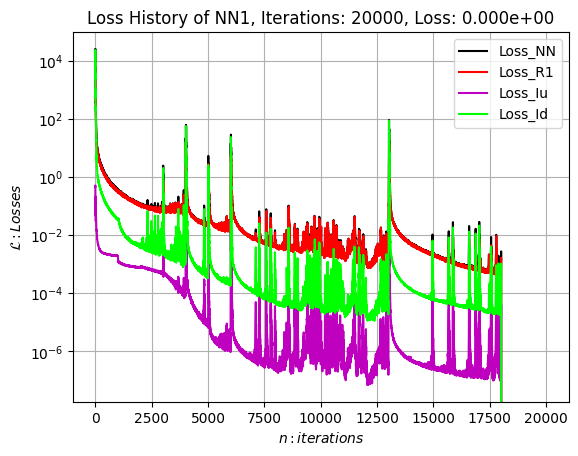

In [13]:
Post.plot_loss_history(domain=1);

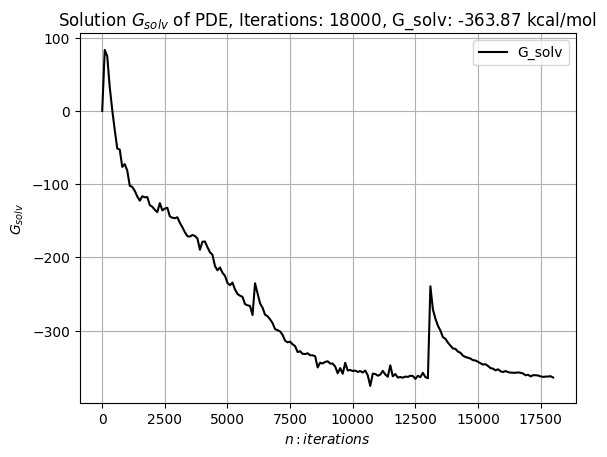

In [14]:
Post.plot_G_solv_history();

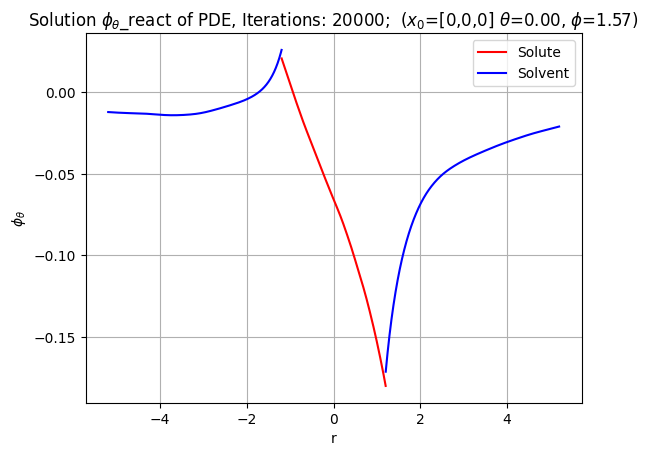

In [15]:
Post.plot_phi_line(value='react');

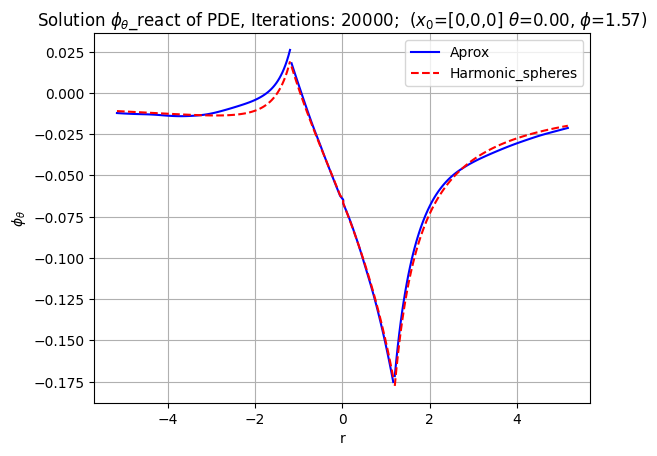

In [16]:
Post.plot_phi_line_aprox_analytic('Harmonic_spheres', value='react');

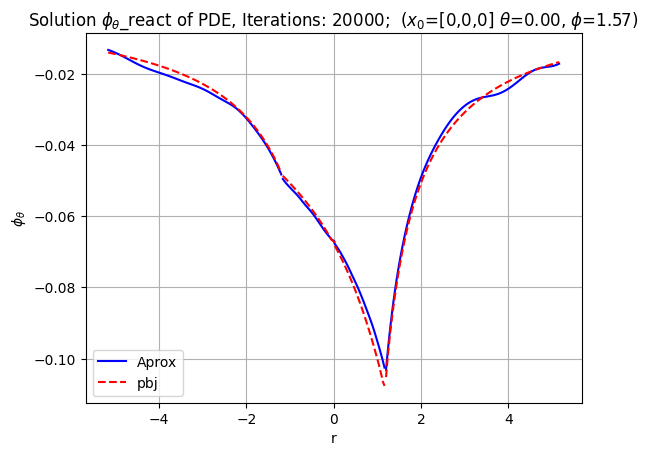

In [15]:
Post.plot_phi_line_aprox_analytic('pbj', value='react');

#### Computations

In [12]:
import bempp.api

u_interface,_,_ = Post.PDE.get_phi_interface(Post.model)
u_interface = u_interface.flatten()
_,du_1,du_2 = Post.PDE.get_dphi_interface(Post.model)
du_1 = du_1.flatten()
du_2 = du_2.flatten()
du_1_interface = (du_1+du_2*Post.PDE.epsilon_1/Post.PDE.epsilon_2)/2

Post.PDE.get_integral_operators()
phi = bempp.api.GridFunction(Post.PDE.space, coefficients=u_interface)
dphi = bempp.api.GridFunction(Post.PDE.space, coefficients=du_1_interface)

phi_q = Post.PDE.slp_q * dphi - Post.PDE.dlp_q * phi

slp_aprox = Post.PDE.slp_q * dphi
dlp_aprox = Post.PDE.dlp_q * phi

In [22]:
phi_q

array([[-0.06457642, -0.06662272, -0.06655833]])

In [19]:
def get_Gsolv(slp,dlp):
  phi_q = slp - dlp
  G_solv = 0.5*np.sum(Post.PDE.qs * phi_q).real
  G_solv *= Post.PDE.to_V*Post.PDE.qe*Post.PDE.Na*(10**-3/4.184) 
  return G_solv

In [21]:
G_solv = get_Gsolv(slp_aprox,dlp_aprox)
print('aprox',G_solv)
G_solv

-277.87266669538843

### Mesh

In [5]:
mol_mesh = Post.mesh.mol_mesh

In [6]:
X_plot = dict()
X_plot['Inner Domain'] = Post.mesh.region_meshes['R1'].vertices
X_plot['Inner Domain Sample'] = Post.mesh.region_meshes['R1'].get_dataset().numpy()

X_plot['Charges'] = Post.mesh.prior_data['Q1'].numpy()

X_plot['Interface'] = Post.mesh.region_meshes['I'].vertices
X_plot['Interface Sample'] = Post.mesh.region_meshes['I'].get_dataset().numpy()

X_plot['Outer Domain'] = Post.mesh.region_meshes['R2'].vertices
X_plot['Outer Domain Sample'] = Post.mesh.region_meshes['R2'].get_dataset().numpy()

X_plot['Outer Border'] = Post.mesh.region_meshes['D2'].vertices
X_plot['Outer Border Sample'] = Post.mesh.region_meshes['D2'].get_dataset().numpy()

In [11]:
s = mol_mesh.contains(X_plot['Outer Domain Sample'])
st = 0
sf = 0
print('check')
for i in range(len(s)):
    if s[i]==True:
        st+=1
    else:
        sf+=1
print(st,sf)

check
0 13769


In [10]:
X_plot['Interface'].shape

(658, 3)